## Projekt: Rekonstrukcja kinematyki rozpadu Higgs → ττ za pomocą sieci neuronowej

### **Autor:** Jakub Kuśmierski  
### **Data:** 23.04.2025  
### **Opis:**   
Celem projektu jest stworzenie modelu regresyjnego o architekturze Fully Connected Neural Network (FCNN), którego zadaniem jest rekonstrukcja parametrów kinematycznych bozonu Higgsa oraz cząstek τ na podstawie danych symulacyjnych. 

Zazwyczaj problem wynika z faktu, że w rozpadzie taonów nie obserwujemy neutrin, które wynoszą ze zdarzenia część energii i pędu. Ich odtworzenie jest trudne w środowisku maszyny hadronowej, a MET (Missing Transverse Energy), który zawiera ich wkład, jest odtwarzany z dużą niedokładnością.

Model będzie oceniany poprzez porównanie jego wyników z obecnie stosowanym narzędziem referencyjnym fastMTT.


### Inicjalizacja środowiska

In [11]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np
import pandas as pd
import ast
import glob

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

### Wstępne wczytanie danych 

In [5]:
df = pd.read_csv('/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/data/sieci/Higgs100-100.csv')
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,tau.pt,tau.eta,tau.phi,H.pt,...,eta1,phi1,mass1,type1,dm2,pt2,eta2,phi2,mass2,type2
0,112.93847,492.961600,1.77682,258.983430,1.77682,233.978200,"[92.95304, 46.2441]","[1.683909, 2.3044999]","[-1.6908998, 2.7341945]","[91.338554, 91.338554]",...,1.684577,-1.702712,0.105658,-1,1,24.717950,2.375069,2.698482,3.664079,-1
1,136.14160,233.098040,1.77682,197.310800,1.77682,35.787228,"[43.819786, 35.51084]","[-2.1852353, 0.11430719]","[1.2113028, -1.5094808]","[18.45391, 18.45391]",...,-2.211803,1.229569,0.105658,-1,1,34.640102,0.116949,-1.524274,3.590217,-1
2,79.42800,111.873474,1.77682,58.120876,1.77682,53.752600,"[27.620544, 53.61327]","[-1.374633, 0.064034745]","[0.0154061, 1.4857656]","[62.72349, 62.72349]",...,-1.348558,0.030219,0.105658,-1,1,41.771297,0.057130,1.466085,0.150325,-1
3,146.46970,429.625700,1.77682,112.535440,1.77682,317.090270,"[64.515366, 89.02436]","[1.1546935, 1.9430921]","[2.5013797, -1.6417618]","[76.78647, 76.78647]",...,1.162106,2.497047,0.000511,-1,3,22.375510,1.941621,-1.618577,0.105658,-1
4,99.35882,103.298640,1.77682,39.748230,1.77682,63.550407,"[39.36661, 57.967106]","[-0.1316975, 0.43450052]","[0.924177, -2.311872]","[19.139568, 19.139568]",...,-0.135670,1.012588,7.861639,-1,1,41.640660,0.426829,-2.313684,1.462912,-1


In [6]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'tau.pt' 'tau.eta' 'tau.phi'
 'H.pt' 'H.eta' 'H.phi' 'METx' 'METy' 'trueMETx' 'trueMETy' 'dm1' 'pt1'
 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2' 'phi2' 'mass2' 'type2']


Z pierwszego oglądu danych można zauważyć dwie rzeczy:
1. Dane dotyczące kinematyki tau: tau.pt, tau.eta, tau.phi — są zapisane w postaci [x, y] gdzie x oznacza wartość dla pierwszego tau, a y dla drugiego i należy je rozdzielić w dwie oddzielne kolumny
2. Dane kinematyki dotyczące Higgsa: H.pt, H.eta, H.phi — także są zapisane w podobnej postaci [x, x] gdzie wartość dla bozonu Higgsa jest podwojona więc trzeba usunąć drugą z nich

In [8]:
df['tau.pt'] = df['tau.pt'].apply(ast.literal_eval)
df['tau.eta'] = df['tau.eta'].apply(ast.literal_eval)
df['tau.phi'] = df['tau.phi'].apply(ast.literal_eval)
df['H.pt'] = df['H.pt'].apply(ast.literal_eval)
df['H.eta'] = df['H.eta'].apply(ast.literal_eval)
df['H.phi'] = df['H.phi'].apply(ast.literal_eval)

In [9]:
df['tau1_pt'] = df['tau.pt'].apply(lambda x: x[0])
df['tau2_pt'] = df['tau.pt'].apply(lambda x: x[1])

df['tau1_eta'] = df['tau.eta'].apply(lambda x: x[0])
df['tau2_eta'] = df['tau.eta'].apply(lambda x: x[1])

df['tau1_phi'] = df['tau.phi'].apply(lambda x: x[0])
df['tau2_phi'] = df['tau.phi'].apply(lambda x: x[1])


df['H_pt'] = df['H.pt'].apply(lambda x: x[0])
df['H_eta'] = df['H.eta'].apply(lambda x: x[0])
df['H_phi'] = df['H.phi'].apply(lambda x: x[0])

In [10]:
df.drop(columns=['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi'], inplace=True)
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,METx,METy,trueMETx,trueMETy,...,type2,tau1_pt,tau2_pt,tau1_eta,tau2_eta,tau1_phi,tau2_phi,H_pt,H_eta,H_phi
0,112.93847,492.961600,1.77682,258.983430,1.77682,233.978200,-21.783560,-16.464653,-28.096622,-33.670624,...,-1,92.953040,46.244100,1.683909,2.304500,-1.690900,2.734195,91.338554,2.342864,-2.197883
1,136.14160,233.098040,1.77682,197.310800,1.77682,35.787228,13.523408,10.390549,10.931591,18.558040,...,-1,43.819786,35.510840,-2.185235,0.114307,1.211303,-1.509481,18.453910,-3.018338,0.306871
2,79.42800,111.873474,1.77682,58.120876,1.77682,53.752600,19.325521,-0.114705,12.726479,15.444277,...,-1,27.620544,53.613270,-1.374633,0.064035,0.015406,1.485766,62.723490,-0.701157,1.032243
3,146.46970,429.625700,1.77682,112.535440,1.77682,317.090270,-18.230460,-65.446990,-18.597929,-55.965706,...,-1,64.515366,89.024360,1.154694,1.943092,2.501380,-1.641762,76.786470,2.344093,-2.427998
4,99.35882,103.298640,1.77682,39.748230,1.77682,63.550407,-9.357310,-19.005812,-1.084180,0.434001,...,-1,39.366610,57.967106,-0.131697,0.434501,0.924177,-2.311872,19.139568,0.940957,-2.507101


### Wczytanie wszystkich danych

Teraz należy wczytać dane ze wszystkich plików i zrobić dla nich to samo, co wcześniej zrobiono dla pierwszego pliku.

In [12]:
data_dir = '/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/data/sieci/'
csv_files = glob.glob(data_dir + "Higgs*.csv")

In [13]:
dfs = []

for file in csv_files:
    df = pd.read_csv(file)

    for col in ['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi']:
        df[col] = df[col].apply(ast.literal_eval)

    
    df['tau1_pt'] = df['tau.pt'].apply(lambda x: x[0])
    df['tau2_pt'] = df['tau.pt'].apply(lambda x: x[1])
    df['tau1_eta'] = df['tau.eta'].apply(lambda x: x[0])
    df['tau2_eta'] = df['tau.eta'].apply(lambda x: x[1])
    df['tau1_phi'] = df['tau.phi'].apply(lambda x: x[0])
    df['tau2_phi'] = df['tau.phi'].apply(lambda x: x[1])
    df['H_pt'] = df['H.pt'].apply(lambda x: x[0])
    df['H_eta'] = df['H.eta'].apply(lambda x: x[0])
    df['H_phi'] = df['H.phi'].apply(lambda x: x[0])

    df.drop(columns=['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi'], inplace=True)

    dfs.append(df)

I na koniec łączymy wszystkie data farme w jeden.

In [14]:
df = pd.concat(dfs, ignore_index=True)
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,METx,METy,trueMETx,trueMETy,...,type2,tau1_pt,tau2_pt,tau1_eta,tau2_eta,tau1_phi,tau2_phi,H_pt,H_eta,H_phi
0,196.73200,282.94920,1.77682,184.299360,1.77682,98.64985,-50.879560,-7.675525,-52.073196,-13.297127,...,-1,76.953780,98.63361,1.519704,-0.002149,-2.765061,1.797632,115.700005,1.164141,2.515362
1,170.96394,454.64020,1.77682,127.403140,1.77682,327.23706,236.432200,-97.585000,246.659970,-110.700200,...,-1,124.511536,228.12059,0.214641,0.901347,-0.984634,-0.233547,330.250270,0.726369,-0.493766
2,403.04907,770.57380,1.77682,453.754670,1.77682,316.81910,18.701082,-1.000554,14.325636,21.218117,...,-1,90.911680,252.49693,-2.290618,-0.699414,-2.556309,0.778071,164.195970,-2.063401,0.884353
3,218.99274,233.65942,1.77682,108.677956,1.77682,124.98147,-43.222538,-18.162619,-33.788174,-6.049116,...,-1,102.301540,117.20386,-0.350866,-0.362030,0.301128,-2.878016,15.459115,-2.346176,-3.129083
4,234.15674,251.93723,1.77682,99.779755,1.77682,152.15747,104.295290,-8.689900,90.916330,-2.842107,...,-1,76.937290,137.41629,0.752438,-0.458990,2.402238,-0.038647,92.950200,-0.019375,0.524304


In [16]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)
print(colored("Shape of the dataset:\n", 'red'), df.shape)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'METx' 'METy' 'trueMETx'
 'trueMETy' 'dm1' 'pt1' 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2'
 'phi2' 'mass2' 'type2' 'tau1_pt' 'tau2_pt' 'tau1_eta' 'tau2_eta'
 'tau1_phi' 'tau2_phi' 'H_pt' 'H_eta' 'H_phi']
Shape of the dataset:
 (35586, 31)


### Wizualizacja danych

array([[<Axes: title={'center': 'H.m'}>, <Axes: title={'center': 'H.E'}>,
        <Axes: title={'center': 't1.m'}>,
        <Axes: title={'center': 't1.E'}>,
        <Axes: title={'center': 't2.m'}>,
        <Axes: title={'center': 't2.E'}>],
       [<Axes: title={'center': 'METx'}>,
        <Axes: title={'center': 'METy'}>,
        <Axes: title={'center': 'trueMETx'}>,
        <Axes: title={'center': 'trueMETy'}>,
        <Axes: title={'center': 'dm1'}>, <Axes: title={'center': 'pt1'}>],
       [<Axes: title={'center': 'eta1'}>,
        <Axes: title={'center': 'phi1'}>,
        <Axes: title={'center': 'mass1'}>,
        <Axes: title={'center': 'type1'}>,
        <Axes: title={'center': 'dm2'}>, <Axes: title={'center': 'pt2'}>],
       [<Axes: title={'center': 'eta2'}>,
        <Axes: title={'center': 'phi2'}>,
        <Axes: title={'center': 'mass2'}>,
        <Axes: title={'center': 'type2'}>,
        <Axes: title={'center': 'tau1_pt'}>,
        <Axes: title={'center': 'tau2_pt'}>],


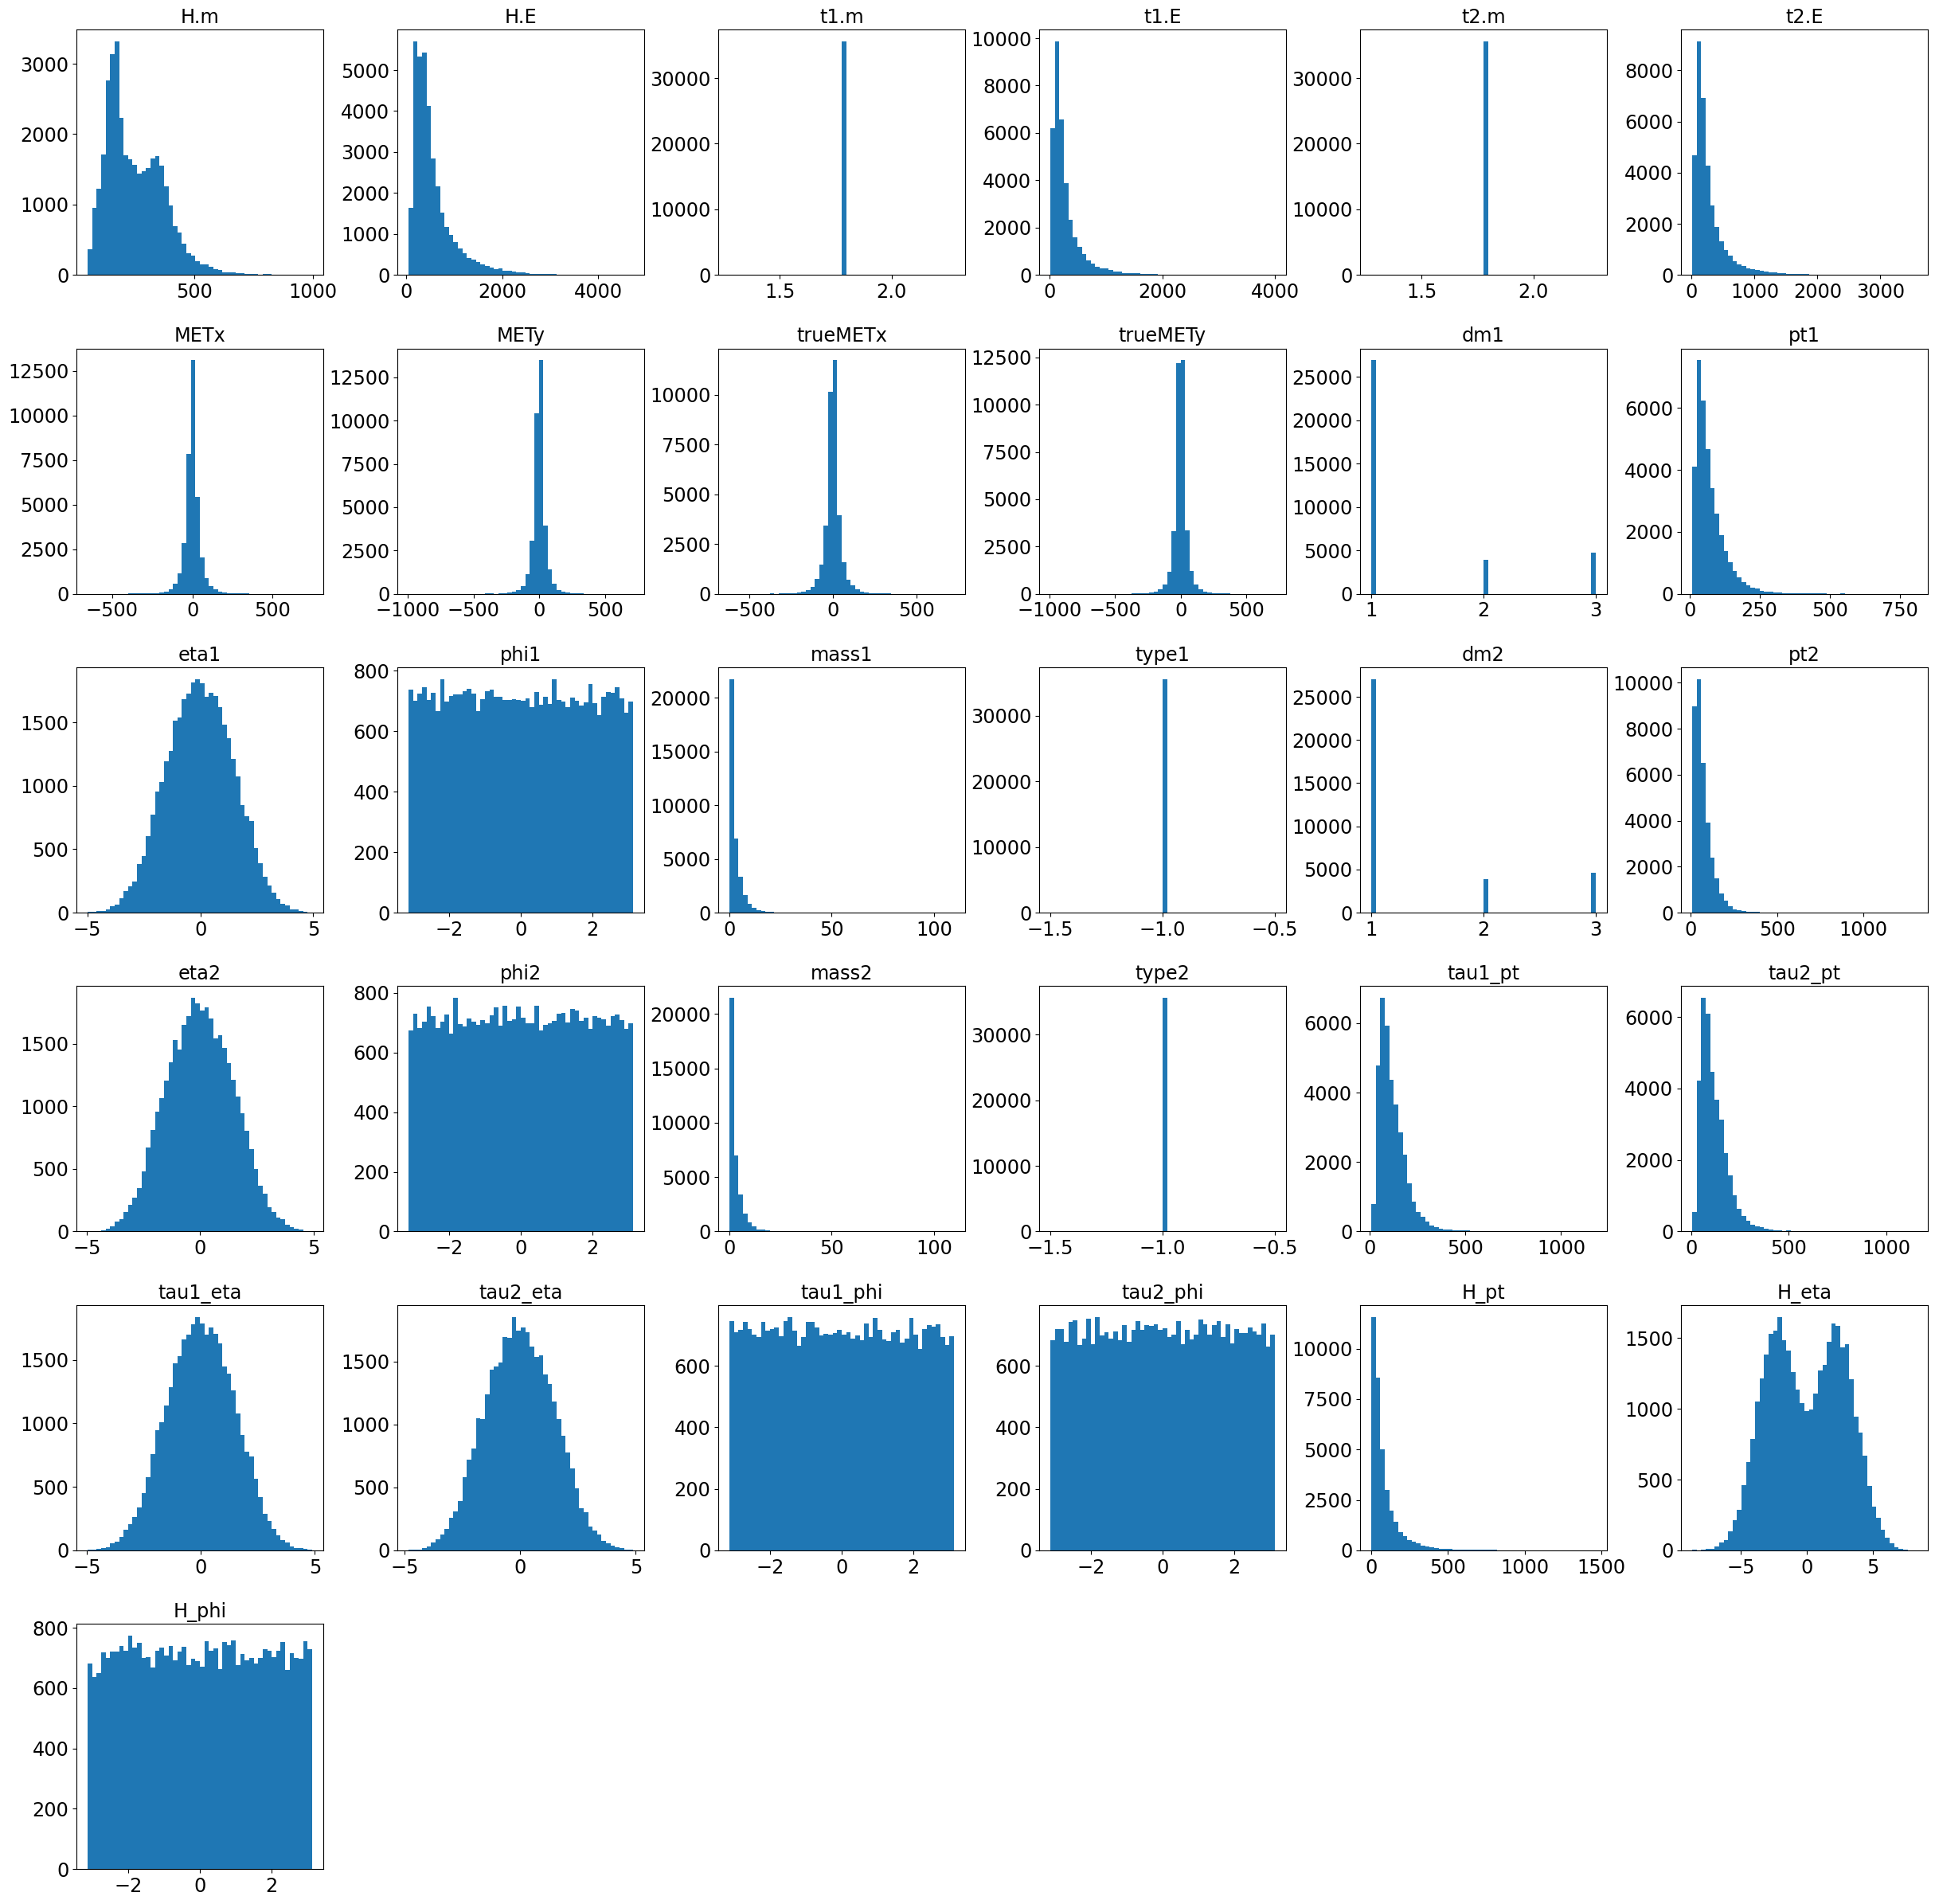

In [19]:
df.hist(figsize=(30, 30), bins=50, grid=False)

### Rozmycie danych MET -- zgodnie z rozkładem normlanym

In [35]:
df['sigma_x'] = np.random.uniform(5, 55, size=len(df))
df['sigma_y'] = np.random.uniform(5, 55, size=len(df))


df['smeared_METx'] = df['trueMETx'] + np.random.normal(0, 1, size=len(df)) * df['sigma_x']
df['smeared_METy'] = df['trueMETy'] + np.random.normal(0, 1, size=len(df)) * df['sigma_y']

df['var_xx'] = df['sigma_x'] ** 2
df['var_yy'] = df['sigma_y'] ** 2

#df['cov_xy'] = 0.0 #Dla uproszczonej pracy z modelem

rho = np.random.uniform(-1, 1, size=len(df))
df['cov_xy'] = rho * df['sigma_x'] * df['sigma_y'] #Dla bardziej realistycznej symulacji

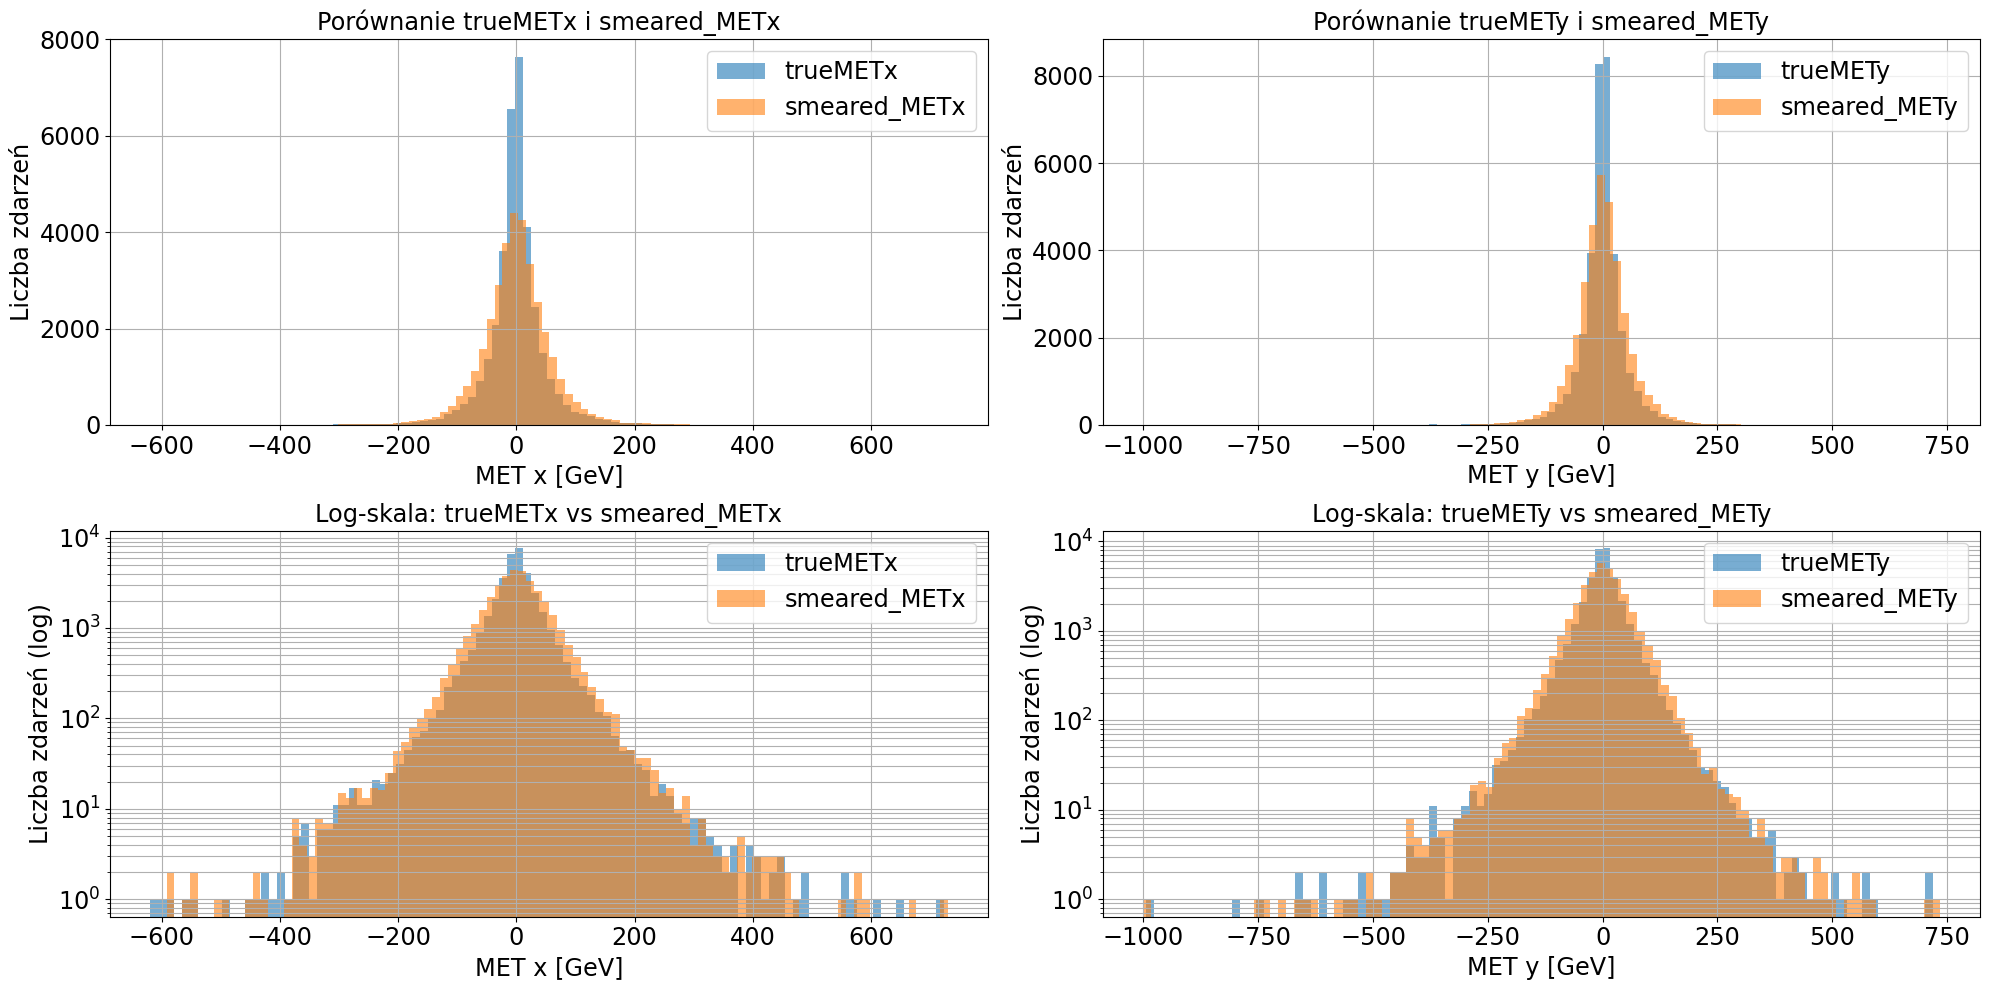

In [36]:
fig, axis = plt.subplots(2, 2, figsize=(20, 10))

# Górny lewy
axis[0, 0].hist(df['trueMETx'], bins=100, alpha=0.6, label='trueMETx')
axis[0, 0].hist(df['smeared_METx'], bins=100, alpha=0.6, label='smeared_METx')
axis[0, 0].set_xlabel('MET x [GeV]')
axis[0, 0].set_ylabel('Liczba zdarzeń')
axis[0, 0].set_title('Porównanie trueMETx i smeared_METx')
axis[0, 0].legend()
axis[0, 0].grid(True)

# Górny prawy
axis[0, 1].hist(df['trueMETy'], bins=100, alpha=0.6, label='trueMETy')
axis[0, 1].hist(df['smeared_METy'], bins=100, alpha=0.6, label='smeared_METy')
axis[0, 1].set_xlabel('MET y [GeV]')
axis[0, 1].set_ylabel('Liczba zdarzeń')
axis[0, 1].set_title('Porównanie trueMETy i smeared_METy')
axis[0, 1].legend()
axis[0, 1].grid(True)

# Dolny lewy – logarytmiczny
axis[1, 0].hist(df['trueMETx'], bins=100, alpha=0.6, label='trueMETx')
axis[1, 0].hist(df['smeared_METx'], bins=100, alpha=0.6, label='smeared_METx')
axis[1, 0].set_yscale('log')
axis[1, 0].set_xlabel('MET x [GeV]')
axis[1, 0].set_ylabel('Liczba zdarzeń (log)')
axis[1, 0].set_title('Log-skala: trueMETx vs smeared_METx')
axis[1, 0].legend()
axis[1, 0].grid(True, which='both')

# Dolny prawy – logarytmiczny
axis[1, 1].hist(df['trueMETy'], bins=100, alpha=0.6, label='trueMETy')
axis[1, 1].hist(df['smeared_METy'], bins=100, alpha=0.6, label='smeared_METy')
axis[1, 1].set_yscale('log')
axis[1, 1].set_xlabel('MET y [GeV]')
axis[1, 1].set_ylabel('Liczba zdarzeń (log)')
axis[1, 1].set_title('Log-skala: trueMETy vs smeared_METy')
axis[1, 1].legend()
axis[1, 1].grid(True, which='both')

plt.tight_layout()
plt.show()

Obecnie columny z danymi wyglądają tak:

In [37]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)
print(colored("Shape of the dataset:\n", 'red'), df.shape)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'METx' 'METy' 'trueMETx'
 'trueMETy' 'dm1' 'pt1' 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2'
 'phi2' 'mass2' 'type2' 'tau1_pt' 'tau2_pt' 'tau1_eta' 'tau2_eta'
 'tau1_phi' 'tau2_phi' 'H_pt' 'H_eta' 'H_phi' 'sigma_x' 'sigma_y'
 'smeared_METx' 'smeared_METy' 'var_xx' 'var_yy' 'cov_xy']
Shape of the dataset:
 (35586, 38)


Teraz należy podzielić dane na wejściowe i etykiety.

In [39]:
input_features = ['dm1', 'pt1', 'eta1', 'phi1', 'mass1',
    'dm2', 'pt2', 'eta2', 'phi2', 'mass2',
    'smeared_METx', 'smeared_METy',
    'var_xx', 'var_yy', 'cov_xy']

output_targets = ['H.m', 'H_pt', 'H_eta', 'H_phi',
    'tau1_pt', 'tau1_eta', 'tau1_phi', 't1.m',
    'tau2_pt', 'tau2_eta', 'tau2_phi', 't2.m']

X = df[input_features].to_numpy(dtype=np.float32)
y = df[output_targets].to_numpy(dtype=np.float32)

A następnie opakować w $\texttt{tf.data.Dataset}$

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))

2025-05-19 13:03:55.111812: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-19 13:03:55.113493: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-19 13:03:55.114178: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-19 13:03:55.114220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-19 13:03:55.114459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
print(colored("Dataset:\n", 'blue'), dataset)
print(colored("Dataset leangth:\n", 'green'), len(dataset))

Dataset:
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(12,), dtype=tf.float32, name=None))>
Dataset leangth:
 35586
